In [29]:
%matplotlib inline

In [30]:
import os
import gym
import math
import random
import numpy as np
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import pkg_resources
import time

import matplotlib.pyplot as plt


In [93]:
from gym.wrappers.human_rendering import HumanRendering
from gym.envs.toy_text.frozen_lake import generate_random_map

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")

wrapped = HumanRendering(env)
wrapped.reset()



resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])
# This is based on the code from gym.

BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 5000
TARGET_UPDATE = 10
device

C:\Users\xande\AppData\Local\Temp\ipykernel_13672\3938856494.py:14: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(40, interpolation=Image.CUBIC),
c:\Users\xande\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


device(type='cuda')

In [32]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

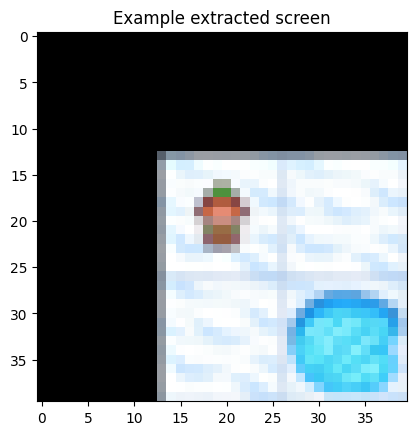

In [33]:
env.reset()

def get_screen():
    screen = env.render().transpose((2, 0, 1))  # transpose into torch order (CHW)
    _, screen_height, screen_width = screen.shape

    row = env.s // env.nrow
    col = env.s % env.ncol

    pad_links = pad_rechts = pad_onder = pad_boven = 0
    breedte_kotje = screen_width/env.ncol
    lengte_kotje = screen_height/env.nrow

    # +2 want pos is zogezegd streep links van agent
    start_scherm_links = int(col*breedte_kotje - breedte_kotje)
    start_scherm_rechts = int(col*breedte_kotje + 2 * breedte_kotje)
    start_scherm_onder = int(row*lengte_kotje + 2 * lengte_kotje)
    start_scherm_boven = int(row*lengte_kotje - lengte_kotje)

    if col == 0:
        start_scherm_links = 0
        pad_links = int(breedte_kotje)

    if row == 0:
        start_scherm_boven = 0
        pad_boven = int(lengte_kotje)

    if col == env.ncol - 1:
        start_scherm_rechts = int(col*breedte_kotje + 1 * breedte_kotje)
        pad_rechts = int(breedte_kotje)

    if row == env.nrow - 1:
        start_scherm_onder = int(row*lengte_kotje + 1 * lengte_kotje)
        pad_onder = int(lengte_kotje)

    slice_range_heigth = slice(start_scherm_boven, start_scherm_onder)
    slice_range_width = slice(start_scherm_links, start_scherm_rechts)

    screen = screen[:, :, slice_range_width]
    screen = screen[:, slice_range_heigth]

    npad = ((0, 0), (pad_boven, pad_onder), (pad_links, pad_rechts))
    screen = np.pad(screen, pad_width=npad, mode='constant', constant_values=0)

    # print(f"shape of screen: {screen.shape}")
    # Convert to float, rescare, convert to torch tensor (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


plt.figure()
example_screen = get_screen()
# print(f"shape of screen: {screen.example_screen}")
plt.imshow(example_screen.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [34]:
# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x192x192
# which is the result of a clamped and down-scaled render buffer in get_screen()

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n
policy_net = torch.load('model/floral-violet-4_policy_net_frozen_lake.pkl')
print('Model loaded')

Model loaded


In [35]:
def select_action(state):
    sample = random.random()

    # eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    eps_threshold = 0


    # wandb.log({"eps_threshold": eps_threshold})
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

3x3 images labellen, label is actie uit model 
```text
    - 0: LEFT
    - 1: DOWN
    - 2: RIGHT
    - 3: UP
```

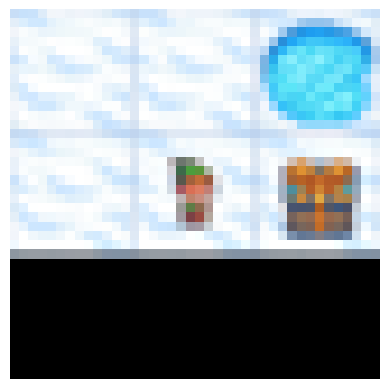

tensor([[2]], device='cuda:0')


In [120]:
env.reset()
env.step(1)
env.step(1)
env.step(2)
env.step(1)
env.step(2)



plt.figure()
plt.axis('off')
example_screen = get_screen()
action = select_action(example_screen)

row = env.s // env.nrow
col = env.s % env.ncol


# print(f"shape of screen: {screen.example_screen}")
plt.imshow(example_screen.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')

plt.savefig('labels/right/right_' + str(row) +'_' + str(col) + '.png',bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()
print(action)